# 11월 25일 연구 일지

이번주에는 모델의 튜닝을 더 해보기로 했다.

일단은 조화평균과 긍부정 threshold 구체화를 생각하고 있다.

다만, 다짜고짜 시도해보기 보다는 진득하게 시각화를 해볼 계획이다.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import matplotlib.font_manager as fm

from sklearn import neighbors
import scipy.sparse

try:
    font_location = "HANDotum.ttf"
    font_name = fm.FontProperties(fname = font_location).get_name()
    matplotlib.rc('font', family=font_name)
except:
    print("폰트 임포트 에러")
    


In [2]:
from pathlib import Path

DATA = Path('.').resolve().parent / 'Data'

In [5]:
rv1 = pd.read_csv(DATA / "review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

In [70]:
pred_norm = pd.read_csv("Data/pred_rate_norm2.csv", index_col=[0])
pred_norm.columns = pred_norm.columns.astype('float64')
pred_norm

,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


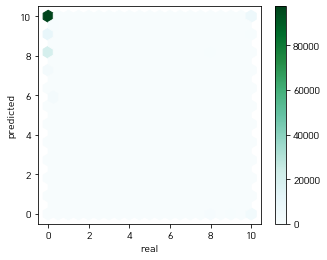

In [42]:
rates = rv_book_pivot.values
rates = rates.reshape((-1, 1))
rates = np.append(rates, pred_norm.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates, columns=["real", "predicted"])
vis_df = vis_df[(vis_df["real"] > 0) | (vis_df["predicted"] > 0)]
ax = vis_df.plot.hexbin(x='real', y='predicted',
                         gridsize=20, sharex=False, figsize=(5, 4))
plt.show()

실제값이 0인데 예측 점수가 기록된 경우가 압도적으로 많아서 제대로 분포를 보기가 어려웠다.

따라서 실제값이 0인 것들을 완전히 제외하고 다시 시각화했다.

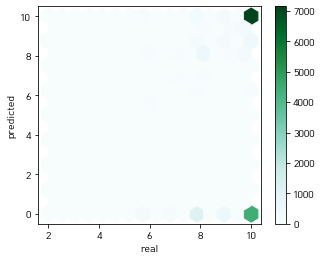

In [51]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_norm.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])
vis_df = vis_df[(vis_df["real"] > 0)]
ax = vis_df.plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(5, 4))
plt.show()

10일 때 10으로 예측된 것들이 많았지만, 0으로 예측된 것이 적지 않았다. 이들이 Recall을 낮추는 요인이 된 것이 명약관화하다.

이번엔 tf-idf 분석을 살펴보자.

In [71]:
pred_tfidf = pd.read_csv("Data/pred_tfidf_comb1.csv", index_col=[0])
pred_tfidf.columns = pred_tfidf.columns.astype('float64')

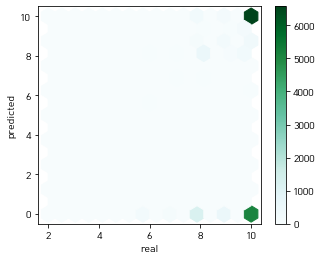

In [78]:
rates_tfidf = rv_book_pivot.values
rates_tfidf = rates_tfidf.reshape((-1, 1))
rates_tfidf = np.append(rates_tfidf, pred_tfidf.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_tfidf, columns=["real", "predicted"])
vis_df = vis_df[(vis_df["real"] > 0)]
ax = vis_df.plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(5, 4))
plt.show()

실제 점수가 10일 때 0으로 관측된 것들의 수가 더 많아졌다.

무엇이 원인인 걸까

In [54]:
# 배열 형태의 점수를 분석하기 위한 인덱스 맵 생성
index_map = []
for idx in us_list:
    for book in book_list:
        index_map.append((idx, book))
index_map[:10]

[("'_'*", 8801748063195.0),
 ("'_'*", 8809124170253.0),
 ("'_'*", 8809254943482.0),
 ("'_'*", 8809254943659.0),
 ("'_'*", 8809264189030.0),
 ("'_'*", 8809332972199.0),
 ("'_'*", 8809416540559.0),
 ("'_'*", 8809469612487.0),
 ("'_'*", 8809474870414.0),
 ("'_'*", 8809474870421.0)]

In [104]:
rates_comb = np.append(rates_norm, rates_tfidf[:, 1].reshape((-1,1)), axis=1)
rates_comb.shape

ana_df = pd.DataFrame(rates_comb, columns=["real", "predicted_norm", "predicted_tfidf"])
ana_df[(ana_df["real"] == 10.0) & (ana_df["predicted_norm"] >= 9.5) & (ana_df["predicted_tfidf"] <= 0.5)]

,real,predicted_norm,predicted_tfidf
352,10.0,10.0,0.0
695,10.0,10.0,0.0
9369,10.0,10.0,0.0
23529,10.0,10.0,0.0
24090,10.0,10.0,0.0
...,...,...,...
5810269,10.0,10.0,0.0
5813999,10.0,10.0,0.0
5824620,10.0,10.0,0.0
5833408,10.0,10.0,0.0


In [105]:
prob_sample = ana_df[(ana_df["real"] == 10.0) & (ana_df["predicted_norm"] >= 9.5) & (ana_df["predicted_tfidf"] <= 0.5)].sample(100)
prob_sample.index

Int64Index([1261954, 3734158, 1404884, 4945853, 2625464, 1027276, 3816216,
            4192002, 4214844, 5184927, 5731033, 5341539,  707096, 5743956,
            4252807, 5435265, 1673674, 1200191, 1507219, 5623957, 4232190,
            3892786, 4562172, 5036557, 2067766, 3866638, 2641611, 1536011,
            4409732, 2729200,  516403, 4165189, 4597855, 4388067, 4317127,
            5600965,  616894, 3616327, 3504396, 3145530, 1963868, 2387932,
            5537450, 3924098, 3481547, 3899934, 4406475, 2872920, 2865391,
            1506492, 4269493, 3639442, 1137080, 2322377, 3355172, 5417556,
             701935, 1171044, 3576726, 1393167, 5278090, 4044898,  988305,
            2842444, 3268929, 3354759, 3574097, 5682947, 3679510, 1721596,
            3227016,  865795,  385012, 2493102, 4417247, 3011458, 2334016,
            4410704, 3217355, 3717701, 2274847, 1439446, 2390201,  381791,
            2388141, 1392341,  480555, 2695982, 3348597, 3092208, 4243272,
            5693217, 2772

이제 문제가 되는 책을 구했으니, 어째서 그런 결과가 나온 것인지 점수 예측 과정을 따라가면서 추적해볼 것이다.

In [111]:
book_sim_table = pd.read_csv("Data/sim_normal.csv", index_col=[0])
book_sim_table.columns = book_sim_table.columns.astype('float64')
book_sim_table_tfidf = pd.read_csv("Data/sim_tfidf.csv", index_col=[0])
book_sim_table_tfidf.columns = book_sim_table_tfidf.columns.astype('float64')

In [17]:
# 상위 n개 근접 이웃 찾기
def get_nearest_books(sim, isbn, n=10) :
    n_book = sim.loc[isbn, :].sort_values(ascending=False).iloc[1:n+1]
    return n_book

In [123]:
def sim_comb_method(a, b):
    # 두 simmilarity의 조합 방법
    return (a + b) / 2.0

user, isbn = index_map[5343644]
k = 10

def prediction_process_comb(user, isbn, k=10):
    nearest_books_a = get_nearest_books(book_sim_table, isbn, k)
    nearest_books_b = get_nearest_books(book_sim_table_tfidf, isbn, k)
    sim_books = set()
    n = 0
    while n < k and len(sim_books) < k:
        sim_books.add(nearest_books_a.index[n])
        sim_books.add(nearest_books_b.index[n])
        n += 1
    sim_books = list(sim_books)
    sim_a = book_sim_table.loc[isbn, sim_books]
    sim_b = book_sim_table_tfidf.loc[isbn, sim_books]
    sim_comb = sim_comb_method(sim_a, sim_b)
    rv_scores = rv_book_pivot.loc[user, sim_books]
    sim_sum = sim_comb[rv_scores>0].sum()
    rate_sum = np.multiply(sim_comb, rv_scores).sum()

    print([(isbn, simm) for isbn, simm in zip(sim_books, sim_comb)])
    print(sim_sum, rate_sum)
    
def prediction_process_norm(user, isbn, k=10):
    sim_books = get_nearest_books(book_sim_table, isbn, k)

    rv_scores = rv_book_pivot.loc[user, sim_books.index]
    sim_sum = sim_books.values[rv_scores>0].sum()
    rate_sum = np.multiply(sim_books.values, rv_scores).sum()

    print([(isbn, simm) for isbn, simm in zip(sim_books.index, sim_books)])
    print(sim_sum, rate_sum)

[(9791187153825.0, 0.4361385066603731), (9791155901090.0, 0.23303940228198097), (9791188102051.0, 0.2948417587829886), (9788983898593.0, 0.3503507327490027), (9791160575972.0, 0.29130726336568147), (9791196872595.0, 0.2725122744465258), (9788992371063.0, 0.26212330403909384), (9791190927741.0, 0.29737514184495173), (9788970948126.0, 0.4354233673938805), (9791187289951.0, 0.3023072535949005)]
0.0 0.0
[(9788970948126.0, 0.4455648118223999), (9791187153825.0, 0.32478490123081544), (9791196872595.0, 0.28127197523150604), (9791155901090.0, 0.28127197523150604), (9788992371063.0, 0.28127197523150604), (9788984143685.0, 0.2719158818022449), (9791165180812.0, 0.2232973731118084), (9791186419663.0, 0.2126216277812812), (9791165180010.0, 0.20501753840599896), (9791156131465.0, 0.20352125845795674)]
0.0 0.0


이게 무슨 일인지 모르겠다.

평점 기반 유사도로 예측한 점수는 10점이어야 하는데 어찌된 일인지 0점이 나왔다. 예측할 때는 사이킷런의 NNeighbors 모델을 사용했는데 이 모델에서는 코드로 직접 계산한 코사인 유사도를 사용해서 그런가 보다.

둘 다 똑같은 코사인 유사도인데 진짜로 다른 수치가 나와버리니까 적잖이 당황스럽다.

In [8]:
book_rv_pivot = rv_book_pivot.T
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(book_rv_pivot)
book_sim_table = nn_model.kneighbors_graph(book_rv_pivot, mode='distance')
book_sim_table

<1425x1425 sparse matrix of type '<class 'numpy.float64'>'
	with 14250 stored elements in Compressed Sparse Row format>

In [9]:
book_sim_table = pd.DataFrame(book_sim_table.todense(), index=book_list, columns=book_list)
book_sim_table

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,1.110223e-16,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8.809124e+12,0.000000e+00,2.220446e-16,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.929354
8.809255e+12,0.000000e+00,0.000000e+00,0.000000,2.717809e-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.741801,0.000000,0.000000,0.0,0.0,0.000000
8.809255e+12,0.000000e+00,0.000000e+00,0.271781,1.110223e-16,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8.809264e+12,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.837414,0.0,0.0,0.000000
9.791197e+12,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.837414,0.000000,0.0,0.0,0.000000
9.791197e+12,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [134]:
prediction_process_norm(user, isbn)

[(9791186419663.0, 0.7873783722187189), (9791165180812.0, 0.7767026268881916), (9788984143685.0, 0.7280841181977551), (9788992371063.0, 0.718728024768494), (9791155901090.0, 0.718728024768494), (9791196872595.0, 0.718728024768494), (9791187153825.0, 0.6752150987691845), (9788970948126.0, 0.5544351881776), (9788980382200.0, 0.0), (9788983795069.0, 0.0)]
0.0 0.0


뭔가 이상하다.

NNeighbors 클래스로 유사도 행렬을 구하는 법까지 써서 점수를 예측했는데 0점이 나온다.

이 참에 새로 점수 예측을 해보는 게 좋을 것 같다.

In [15]:
def predict_score_one(sim_table, user_list, item_list, k=10):
    val = np.zeros(rv_book_pivot.shape)
    predicted_scores = pd.DataFrame(val, index=user_list, columns=item_list)

    for i in range(predicted_scores.shape[0]):
        cur_user = user_list[i]
        # 밑에 부분은 행렬로 가능할 것 같은데..
        for j in range(predicted_scores.shape[1]):
            isbn = item_list[j]
            sim_books = get_nearest_books(sim_table, isbn, k)
            nearest_books = sim_books.index
            rv_scores = rv_book_pivot.loc[cur_user, nearest_books]
            sim_sum = sim_books.values[rv_scores>0].sum()
            rate_sum = np.multiply(sim_books.values, rv_scores).sum()
            predicted_scores.iloc[i, j] = 0
            if sim_sum > 0:
                predicted_scores.iloc[i, j] = rate_sum / sim_sum
    
    return predicted_scores

In [18]:
pred_norm = predict_score_one(book_sim_table, us_list, book_list)
pred_norm

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
pred_norm.to_csv("Data/pred_rate_norm3.csv")

이제 이 결과를 갖고 평가하면 될 듯 하다.

In [4]:
pred_norm = pd.read_csv("Data/pred_rate_norm3.csv", index_col=[0])
pred_norm.columns = pred_norm.columns.astype('float64')

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


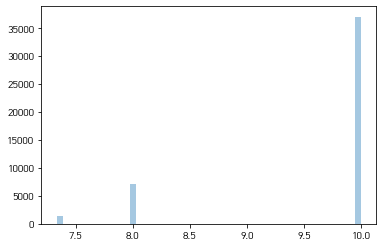

In [11]:
ax = sns.distplot(pred_norm[pred_norm>0].values, kde=False)
plt.show()

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


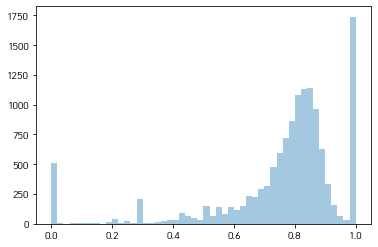

In [12]:
ax = sns.distplot(book_sim_table[book_sim_table>0].values, kde=False)
plt.show()

In [19]:
def f1_with_rating_thresfunc(real_score, predicted_score, threshold_hold=8.0, threshold_func=None):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    if threshold_func is None:
        threshold_func = lambda x : 1 if x >= rate_threshold else 0
        
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = threshold_func(real_score.iloc[j, i])
            pred_rate = threshold_func(predicted_score.iloc[j, i])
                
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate == 1:
                tr += 1
                if pred_rate == 1:
                    tp += 1 
            
            if pred_rate == 1:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5
    
f1_with_rating(rv_book_pivot, pred_norm, rate_threshold=9.0)

MAP:0.7975474283937366 Recall:0.7288444703822585


(0.7616497879980845, 0.7827898281428882)

갑자기 원래 썼던 모델보다 결과가 현격히 좋아졌다.

In [50]:
def predict_score_two(sim_table_a, sim_table_b, comb_method, user_list, item_list, k=10):
    val = np.zeros(rv_book_pivot.shape)
    predicted_scores = pd.DataFrame(val, index=user_list, columns=item_list)
    
    ori_size = len(item_list)
    sim_comb = comb_method(sim_table_a.values, sim_table_b.values)
    sim_comb = sim_comb.reshape((ori_size, ori_size))
    sim_comb = pd.DataFrame(sim_comb, index=item_list, columns=item_list)
    

    for i in range(predicted_scores.shape[0]):
        cur_user = user_list[i]
        # 밑에 부분은 행렬로 가능할 것 같은데..
        for j in range(predicted_scores.shape[1]):
            isbn = item_list[j]
            sim_books = get_nearest_books(sim_comb, isbn, k)
            nearest_books = sim_books.index
            rv_scores = rv_book_pivot.loc[cur_user, nearest_books]
            sim_sum = sim_books.values[rv_scores>0].sum()
            rate_sum = np.multiply(sim_books.values, rv_scores).sum()
            predicted_scores.iloc[i, j] = 0
            if sim_sum > 0:
                predicted_scores.iloc[i, j] = rate_sum / sim_sum
    
    return predicted_scores

여기서부터는 TF-IDF를 계산한다.

계산값을 이용하여 NNeighbors 클래스로 유사도 행렬을 구한다.

In [21]:
import MeCab
import re

def pos_mecab(sentence) :
    """

    :param sentence:
    :return:
    """
    m = MeCab.Tagger()

    # 저\tNP,*,F,저,Inflect,NP,NP,제/NP/*
    out = m.parse(sentence)

    sentences = out.split('\n')
    p = re.compile('(.*)\t(.*),(.*),(.*),(.*),(.*),(.*),(.*),(.*)')
    sentences = [p.findall(s) for s in sentences]

    tags = []
    for s in sentences :
        if len(s) > 0 and len(s[0]) > 0 :
            s = s[0]
            tags.append((s[0], s[1]))
    return tags

def token_mecab(sentence):
    res = pos_mecab(sentence)
    return [word for word, pos in res]

In [22]:
# 각 책 별로 합친 문서 리스트 만들기
# 책간 TF-IDF 유사도를 비교하기 위해서
book_rvs= []

for isbn in book_list:
    rvs = rv1[rv1["BookCode"] == isbn]["Content"]
    rv_doc = '\n\n'.join(rvs.tolist())
    book_rvs.append(rv_doc)

book_rvs = pd.DataFrame(book_rvs, index=book_list, columns=["ReviewDoc"])
book_rvs.head()

,ReviewDoc
BookCode,
8.801748e+12,"에르베튈레, 프랑스 일러스터의 책입니다. 예술의전당 전시회 보러 아이와 오가면, 알..."
8.809124e+12,책값이 왜 9900원 막 이래가지고 ...그냥 만원 하지.. 진짜 장사심보100원끼...
8.809255e+12,아이들이 좋아하는 흔한남매!떨어질 줄 모르는 유튜브 인기와출간 즉시 베스트셀러가 되...
8.809255e+12,힘든 코로나시대에 집콕생활에 힘들어 하는 아홉살난 남자아이조카를 위해 사줬습니다. ...
8.809264e+12,카드러버 아이와 함께 감정도 배우고 인사도 배우고 여러 표현법을 놀면서 익히니 재밌...


In [23]:
# 책 리뷰 문서 tf-idf 구하기
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer(tokenizer=token_mecab).fit(book_rvs["ReviewDoc"])
tfidf_mat = pd.DataFrame(tfidfv.transform(book_rvs["ReviewDoc"]).toarray(), index=book_list)
tfidf_mat

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,0,1,2,3,4,5,6,7,8,9,...,76116,76117,76118,76119,76120,76121,76122,76123,76124,76125
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,0.055195,0.000000,0.002536,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809124e+12,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.059265,0.010129,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.051259,0.008380,0.005939,0.000000,0.0000,0.003405,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809264e+12,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.020531,0.002969,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.102430,0.019258,0.004549,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.057519,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn import neighbors

nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(tfidf_mat)
book_sim_table_tfidf = nn_model.kneighbors_graph(tfidf_mat, mode='distance')
book_sim_table_tfidf

<1425x1425 sparse matrix of type '<class 'numpy.float64'>'
	with 14250 stored elements in Compressed Sparse Row format>

In [25]:
scipy.sparse.save_npz('Data/sim_tfidf.npz', book_sim_table_tfidf)

In [27]:
book_sim_table_tfidf = pd.DataFrame(book_sim_table_tfidf.todense(), index=book_list, columns=book_list)
book_sim_table_tfidf

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
8.809124e+12,0.0,3.330669e-16,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
8.809255e+12,0.0,0.000000e+00,4.440892e-16,6.240097e-01,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
8.809255e+12,0.0,0.000000e+00,0.000000e+00,6.661338e-16,0.0,0.573254,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
8.809264e+12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.778135e-01,0.0,0.0,0.000000e+00
9.791197e+12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.440892e-16,0.0,0.0,0.000000e+00
9.791197e+12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00


In [28]:
def sim_comb_mean(a, b):
    # 두 simmilarity의 조합 방법
    return (a + b) / 2.0

pred_tfidf = predict_score_two(book_sim_table, book_sim_table_tfidf, sim_comb_mean, us_list, book_list)
pred_tfidf

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,9.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
f1_with_rating(rv_book_pivot, pred_tfidf, rate_threshold=9.0)

MAP:0.7852639573720467 Recall:0.5250218850306391


(0.6292989663844456, 0.71443767510489)

In [34]:
# 데이터 저장하기
pred_tfidf_csr = scipy.sparse.csr_matrix(pred_tfidf)
scipy.sparse.save_npz('Data/pred_tfidf2_comb1.npz', pred_tfidf_csr)

In [35]:
sim_table_csr = scipy.sparse.csr_matrix(book_sim_table)
scipy.sparse.save_npz('Data/sim_norm.npz', sim_table_csr)

In [37]:
pred_norm_csr = scipy.sparse.csr_matrix(pred_norm)
scipy.sparse.save_npz('Data/pred_norm.npz', pred_norm_csr)

# 11월 27일 연구일지

역시나 TF-IDF 통합 모델의 결과가 더 좋지 않았다.

이제부터는 다시 그 원인을 살펴봐야 한다.

이 밑으로는 나중에 원인 분석하면서 풀 부분이다.

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


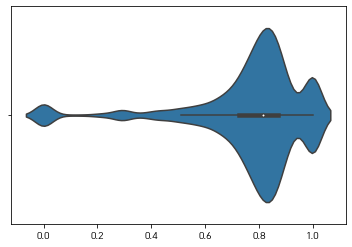

In [32]:
ax = sns.violinplot(book_sim_table[book_sim_table>0].values)
plt.show()

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


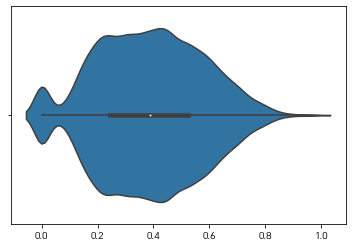

In [33]:
ax = sns.violinplot(book_sim_table_tfidf[book_sim_table_tfidf>0].values)
plt.show()

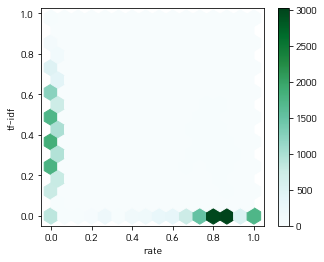

In [36]:
sim_tfidf = book_sim_table_tfidf.values
sim_tfidf = sim_tfidf.reshape((-1, 1))
sim_comb = np.append(sim_tfidf, book_sim_table.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(sim_comb, columns=["tf-idf", "rate"])
vis_df = vis_df[(vis_df["rate"] > 0) | (vis_df["tf-idf"] > 0)]
ax = vis_df.plot.hexbin(x='rate', y='tf-idf',
                         gridsize=15, sharex=False, figsize=(5, 4))
plt.show()

# 12월 1일 연구일지

## 예측 재현해보기

In [5]:
pred_norm_csr = scipy.sparse.load_npz(DATA / "pred_norm.npz")
pred_tfidf_csr = scipy.sparse.load_npz(DATA / "pred_tfidf_comb1.npz")

In [25]:
# 배열 형태의 점수를 분석하기 위한 인덱스 맵 생성
index_map = []
for idx in us_list:
    for book in book_list:
        index_map.append((idx, book))
index_map[:10]

[("'_'*", 8801748063195.0),
 ("'_'*", 8809124170253.0),
 ("'_'*", 8809254943482.0),
 ("'_'*", 8809254943659.0),
 ("'_'*", 8809264189030.0),
 ("'_'*", 8809332972199.0),
 ("'_'*", 8809416540559.0),
 ("'_'*", 8809469612487.0),
 ("'_'*", 8809474870414.0),
 ("'_'*", 8809474870421.0)]

In [7]:
rates_norm = pred_norm_csr.todense().reshape((-1,1))
rates_tfidf = pred_tfidf_csr.todense().reshape((-1,1))
rates = rv_book_pivot.values.reshape((-1,1))

rates_comb = np.append(rates_norm, rates_tfidf, axis=1)
rates_comb = np.append(rates_comb, rates, axis=1)

ana_df = pd.DataFrame(rates_comb, columns=["predicted_norm", "predicted_tfidf", "real"])
ana_df[(ana_df["real"] == 10.0) & (ana_df["predicted_norm"] >= 9.5) & (ana_df["predicted_tfidf"] <= 0.5)]

,predicted_norm,predicted_tfidf,real
2074,10.0,0.0,10.0
2075,10.0,0.0,10.0
2076,10.0,0.0,10.0
3592,10.0,0.0,10.0
7161,10.0,0.0,10.0
...,...,...,...
5836204,10.0,0.0,10.0
5836661,10.0,0.0,10.0
5837583,10.0,0.0,10.0
5839176,10.0,0.0,10.0


In [8]:
# 위에서 했던 과정을 재실행
prob_sample = ana_df[(ana_df["real"] == 10.0) & (ana_df["predicted_norm"] >= 9.5) & (ana_df["predicted_tfidf"] <= 0.5)].sample(100)
prob_sample.index

Int64Index([5611296,  662474, 3060936, 5645481,  814080, 3532149, 5226369,
            3143390, 3066293, 2518196, 5506142, 5475009, 3459831,  747839,
            4091783, 1739806, 3040437, 2138195, 3562680, 5820441, 3195025,
            3386729, 1949936, 1265436, 4066718, 4540050,  425877, 1832644,
            2417527, 1626239, 2887250, 3284521, 4581306,  115751,  194943,
            3679176, 2992003, 3456867, 3158983, 1399057, 2283733, 2433625,
            3044883, 5261275, 3361415, 3505377, 3143364, 5568442, 4547106,
             412774, 1059925, 2625464, 1034725,  588200, 3865874,  624574,
            2025665, 1288431, 4539554, 3732949, 4116844, 3669289, 5790514,
            1535035, 2705638, 3622286,  578864,  659298, 5539760, 3656858,
            3616213, 2862911,  802222, 3618011, 3397138, 3330533, 2120779,
            2368543, 1781150, 2966418, 3300908, 1025440, 5141045, 4653475,
            1537086, 3059671, 2112004, 4805031, 1833733, 2432088, 1832373,
            1926110, 5258

In [9]:
# 유사도 정보 갖고오기
book_sim_csr = scipy.sparse.load_npz(DATA / "sim_norm.npz")
book_sim_table = pd.DataFrame(book_sim_csr.todense(), index=book_list, columns=book_list)
book_sim_tfidf_csr = scipy.sparse.load_npz(DATA / "sim_tfidf.npz")
book_sim_tfidf = pd.DataFrame(book_sim_tfidf_csr.todense(), index=book_list, columns=book_list)

In [24]:
# 상위 n개 근접 이웃 찾기
def get_nearest_books(sim, isbn, n=10) :
    n_book = sim.loc[isbn, :].sort_values(ascending=False).iloc[1:n+1]
    return n_book

# 테스트 프레임 구성하기
def test_predict(sim_table, user, isbn, k=10):
    sim_books = get_nearest_books(sim_table, isbn, k)
    nearest_books = sim_books.index
    rv_scores = rv_book_pivot.loc[user, nearest_books]
    sim_sum = sim_books.values[rv_scores>0].sum()
    rate_sum = np.multiply(sim_books.values, rv_scores).sum()
    
    print([(isbn, simm, rate) for isbn, simm, rate in zip(sim_books.index, sim_books, rv_scores)])
    print(sim_sum, rate_sum)
    if sim_sum > 0:
        print(rate_sum / sim_sum)

In [11]:
# 조합 유사도 계산하기
def sim_comb_mean(a, b):
    # 두 simmilarity의 조합 방법
    return (a + b) / 2.0

ori_size = book_sim_table.shape[0]
sim_comb = sim_comb_mean(book_sim_table.values, book_sim_tfidf.values)
sim_comb = sim_comb.reshape((ori_size, ori_size))
sim_comb = pd.DataFrame(sim_comb, index=book_list, columns=book_list)

In [19]:
# 이 셀에서 여러 인덱스를 돌려가면서 예측 출력값 확인
user, isbn = index_map[412774]

test_predict(book_sim_table, user, isbn)
test_predict(sim_comb, user, isbn)

[(9791160509465.0, 0.8565561723626883, 0.0), (9791188108787.0, 0.8415927920799442, 0.0), (9788965022619.0, 0.8415927920799442, 0.0), (9791125479925.0, 0.7971397935166051, 0.0), (9788954753920.0, 0.7971397935166051, 0.0), (9791125480006.0, 0.7971397935166051, 0.0), (9788999719240.0, 0.7971397935166051, 0.0), (9791164421053.0, 0.19002101913890312, 10.0), (9791164421114.0, 1.1102230246251565e-16, 10.0), (9788984077997.0, 0.0, 0.0)]
0.19002101913890324 1.9002101913890324
10.0
[(9791160509465.0, 0.42827808618134416, 0.0), (9788965022619.0, 0.4207963960399721, 0.0), (9791188108787.0, 0.4207963960399721, 0.0), (9788954753920.0, 0.39856989675830257, 0.0), (9791125480006.0, 0.39856989675830257, 0.0), (9791125479925.0, 0.39856989675830257, 0.0), (9788999719240.0, 0.39856989675830257, 0.0), (9788901230658.0, 0.19869993743421271, 0.0), (9791196316808.0, 0.19816543952172277, 0.0), (9791187962755.0, 0.19375712988287702, 0.0)]
0.0 0.0


In [22]:
test_predict(book_sim_table, user, isbn, k=20)
test_predict(sim_comb, user, isbn, k=20)

[(9791160509465.0, 0.8565561723626883, 0.0), (9791188108787.0, 0.8415927920799442, 0.0), (9788965022619.0, 0.8415927920799442, 0.0), (9791125479925.0, 0.7971397935166051, 0.0), (9788954753920.0, 0.7971397935166051, 0.0), (9791125480006.0, 0.7971397935166051, 0.0), (9788999719240.0, 0.7971397935166051, 0.0), (9791164421053.0, 0.19002101913890312, 10.0), (9791164421114.0, 1.1102230246251565e-16, 10.0), (9788984077997.0, 0.0, 0.0), (9788980382200.0, 0.0, 0.0), (9788980400850.0, 0.0, 0.0), (9788980815555.0, 0.0, 0.0), (9788981602697.0, 0.0, 0.0), (9788982501319.0, 0.0, 0.0), (9788984058668.0, 0.0, 0.0), (9788984057029.0, 0.0, 0.0), (9788983795069.0, 0.0, 0.0), (9788984077980.0, 0.0, 0.0), (9788983799258.0, 0.0, 0.0)]
0.19002101913890324 1.9002101913890324
10.0
[(9791160509465.0, 0.42827808618134416, 0.0), (9788965022619.0, 0.4207963960399721, 0.0), (9791188108787.0, 0.4207963960399721, 0.0), (9788954753920.0, 0.39856989675830257, 0.0), (9791125480006.0, 0.39856989675830257, 0.0), (97911254

문제가 되는 부분을 확인해보니, `k=10`일 때는 새로이 제공된 정보 때문에 평점이 있는 점수들이 계산 범위 안에 들어오지 못했다.

이를 `k=20`으로 늘리니 계산에 포함되는 점수 범위가 많아져서 더 올바르게 점수가 채점되었다. 즉, k를 늘리고 모델을 재평가해보면 좋을 것 같다.

In [51]:
pred_tfidf_k20 = predict_score_two(book_sim_table, book_sim_tfidf, sim_comb_mean, us_list, book_list, k=20)
pred_tfidf_k20

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,9.488897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,9.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# 평가 함수 선언
def f1_with_rating_thresfunc(real_score, predicted_score, rate_threshold=8.0, threshold_func=None):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    if threshold_func is None:
        threshold_func = lambda x : 1 if x >= rate_threshold else 0
        
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = threshold_func(real_score.iloc[j, i])
            pred_rate = threshold_func(predicted_score.iloc[j, i])
                
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate == 1:
                tr += 1
                if pred_rate == 1:
                    tp += 1 
            
            if pred_rate == 1:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5

In [55]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k20, rate_threshold=9.0)

MAP:0.7760801833625174 Recall:0.8470965859352203


(0.8100348479270028, 0.7893146330505317)

In [59]:
pred_norm_k20 = predict_score_one(book_sim_table, us_list, book_list, k=20)
pred_norm_k20

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k20, rate_threshold=9.0)

MAP:0.7975474283937366 Recall:0.7288444703822585


(0.7616497879980845, 0.7827898281428882)

In [63]:
# 배타적 평균
def sim_comb_excl(a, b):
    comb = np.zeros(a.shape)
    bool_idx = (a == 0.0) & (b > 0)
    comb[bool_idx] = b[bool_idx]
    bool_idx = (b == 0.0) & (a > 0)
    comb[bool_idx] = a[bool_idx]
    bool_idx = (a > 0) & (b > 0)
    comb[bool_idx] = (a[bool_idx] + b[bool_idx]) / 2.0
    
    return comb

ori_size = book_sim_table.shape[0]
sim_comb = sim_comb_excl(book_sim_table.values, book_sim_tfidf.values)
sim_comb = sim_comb.reshape((ori_size, ori_size))
sim_comb = pd.DataFrame(sim_comb, index=book_list, columns=book_list)
sim_comb

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,1.110223e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00
8.809124e+12,0.000000e+00,2.775558e-16,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,9.293544e-01
8.809255e+12,0.000000e+00,0.000000e+00,4.440892e-16,4.478953e-01,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.741801,0.000000,0.000000e+00,0.0,0.0,0.000000e+00
8.809255e+12,0.000000e+00,0.000000e+00,2.717809e-01,3.885781e-16,0.0,0.573254,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00
8.809264e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,6.076140e-01,0.0,0.0,0.000000e+00
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.837414,4.440892e-16,0.0,0.0,0.000000e+00
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00


In [67]:
pred_tfidf_exl_k20 = predict_score_two(book_sim_table, book_sim_tfidf, sim_comb_excl, us_list, book_list, k=20)
pred_tfidf_exl_k20

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,9.488897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_exl_k20, rate_threshold=9.0)

MAP:0.7755088488806653 Recall:0.849503939305515


(0.8108217078411459, 0.7892583418905511)

In [70]:
# 결과물 저장
pred_tfidf_k20_csr = scipy.sparse.csr_matrix(pred_tfidf_k20)
scipy.sparse.save_npz("Data/pred_tfidf_comb1_k20.npz", pred_tfidf_k20_csr)

pred_norm_k20_csr = scipy.sparse.csr_matrix(pred_norm_k20)
scipy.sparse.save_npz("Data/pred_norm_k20.npz", pred_norm_k20_csr)

pred_tfidf_exl_k20_csr = scipy.sparse.csr_matrix(pred_tfidf_exl_k20)
scipy.sparse.save_npz("Data/pred_tfidf_comb2_k20.npz", pred_tfidf_exl_k20_csr)

# 12월 2일 연구일지

드디어 결론을 찾아냈다. k의 개수를 늘리면 tf-idf 유사도를 사용한 모델의 점수가 일반 평점 기반 모델보다 훨씬 높아진다.

k의 개수를 30개, 40개로 시간이 허락하는만큼 늘려가면서 점수가 어떻게 변하는지 살펴볼까 한다.

In [71]:
pred_norm_k30 = predict_score_one(book_sim_table, us_list, book_list, k=30)
pred_norm_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k30, rate_threshold=9.0)

MAP:0.7975474283937366 Recall:0.7288444703822585


(0.7616497879980845, 0.7827898281428882)

In [73]:
pred_tfidf_k30 = predict_score_two(book_sim_table, book_sim_tfidf, sim_comb_mean, us_list, book_list, k=30)
pred_tfidf_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,9.488897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,9.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k30, rate_threshold=9.0)

MAP:0.7760800545357827 Recall:0.84695068573096


(0.8099680653777087, 0.7892891879332199)

In [75]:
pred_tfidf_exl_k30 = predict_score_two(book_sim_table, book_sim_tfidf, sim_comb_excl, us_list, book_list, k=30)
pred_tfidf_exl_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,9.488897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_exl_k30, rate_threshold=9.0)

MAP:0.7755125244467499 Recall:0.8493580391012547


(0.8107572527183581, 0.7892361958271946)

In [77]:
# 결과물 저장
pred_norm_k30_csr = scipy.sparse.csr_matrix(pred_norm_k30)
scipy.sparse.save_npz("Data/pred_norm_k30.npz", pred_norm_k30_csr)

pred_tfidf_k30_csr = scipy.sparse.csr_matrix(pred_tfidf_k30)
scipy.sparse.save_npz("Data/pred_tfidf_comb1_k30.npz", pred_tfidf_k30_csr)

pred_tfidf_exl_k30_csr = scipy.sparse.csr_matrix(pred_tfidf_exl_k30)
scipy.sparse.save_npz("Data/pred_tfidf_comb2_k30.npz", pred_tfidf_exl_k30_csr)

# 12월 3일 연구일지

`k=10`에서 `k=20`으로 오를 때 극적인 정확도 상승을 보여준 후에 `k=30`으로 올리니 큰 변화가 없었다.

k를 더 올리기 보다는 ui를 만들어서 결과물을 볼 수 있게 하고, 보고서를 써서 결과물을 정리하는 것이 좋을 것 같다.

# 12월 13일 연구일지

더 많은 정보를 제공하기 위해 마지막으로 TF-IDF 유사도만 사용한 내용 기반 협업 필터링 결과를 살펴보려고 한다.

In [10]:
pred_tfidf = predict_score_one(book_sim_tfidf, us_list, book_list)
pred_tfidf

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,9.488897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf, rate_threshold=9.0)

MAP:0.7704810046950556 Recall:0.5818500145900204


(0.663009836245792, 0.7235661645786894)

In [13]:
# 결과 저장
pred_tfidf_csr = scipy.sparse.csr_matrix(pred_tfidf)
scipy.sparse.save_npz(DATA / "pred_tfidf_only.npz", pred_tfidf_csr)

# 12월 18일 일지

NearestNeighbors 클래스로 유사도를 계산할 때 이웃 수를 10으로 제한한 걸 발견했다. 실험 과정에 있어 중대한 결함으로, 재실험을 할 필요가 있다.

In [4]:
# 1개만 리뷰한 유저 삭제하기

user_group = rv1.groupby(["Author"]).groups
user_1_rv = []
for user in user_group.keys() :
    if len(user_group[user]) == 1 :
        user_1_rv.append(user)

rv1 = rv1[~rv1["Author"].isin(user_1_rv)]
rv1.to_csv(DATA / "review1_pre.csv")

In [11]:
from sklearn import neighbors
from scipy import sparse

book_rv_pivot = rv_book_pivot.T
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=100)
nn_model.fit(book_rv_pivot)
book_sim_table = nn_model.kneighbors_graph(book_rv_pivot, mode='distance')

sparse.save_npz(DATA / "sim_rate.npz", book_sim_table)

In [7]:
# tf-idf 행렬 구하기

import MeCab
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def pos_mecab(sentence) :
    """

    :param sentence:
    :return:
    """
    m = MeCab.Tagger()

    # 저\tNP,*,F,저,Inflect,NP,NP,제/NP/*
    out = m.parse(sentence)

    sentences = out.split('\n')
    p = re.compile('(.*)\t(.*),(.*),(.*),(.*),(.*),(.*),(.*),(.*)')
    sentences = [p.findall(s) for s in sentences]

    tags = []
    for s in sentences :
        if len(s) > 0 and len(s[0]) > 0 :
            s = s[0]
            tags.append((s[0], s[1]))
    return tags

def token_mecab(sentence):
    res = pos_mecab(sentence)
    return [word for word, pos in res]

book_rvs= []

for isbn in book_list:
    rvs = rv1[rv1["BookCode"] == isbn]["Content"]
    rv_doc = '\n\n'.join(rvs.tolist())
    book_rvs.append(rv_doc)

book_rvs = pd.DataFrame(book_rvs, index=book_list, columns=["ReviewDoc"])

tfidfv = TfidfVectorizer(tokenizer=token_mecab).fit(book_rvs["ReviewDoc"])

In [13]:
from sklearn import neighbors
from scipy import sparse

tfidf_mat = pd.DataFrame(tfidfv.transform(book_rvs["ReviewDoc"]).toarray(), index=book_list)

nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=100)
nn_model.fit(tfidf_mat)
book_sim_table_tfidf = nn_model.kneighbors_graph(tfidf_mat, mode='distance')

sparse.save_npz(DATA / "sim_tfidf.npz", book_sim_table_tfidf)

In [14]:
book_sim_rate = pd.DataFrame(book_sim_table.todense(), index=book_list, columns=book_list)
book_sim_tfidf = pd.DataFrame(book_sim_table_tfidf.todense(), index=book_list, columns=book_list)

---

## 평점 유사도

여기서부터는 예측 파트

In [83]:
# 평점 유사도 k=10에 대한 예측
pred_norm = predict_score_one(book_sim_rate, us_list, book_list, k=10)
pred_norm

KeyboardInterrupt: 

In [21]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm, rate_threshold=9.0)

MAP:0.8348622334289627 Recall:0.16553304746414313


(0.27628536909698537, 0.46158251347693036)

평점 유사도 모델 k=10에 대한 평가 결과이다.

nearestneighbors에서 이웃수를 10으로 해서 유사도를 구했을 때보다 명백히 성능이 낮다.

이건 nearestneighbors에 관해 무언가 놓치고 있는 게 분명한데 그게 무엇인지 모르겠다.

In [23]:
pred_norm_csr = sparse.csr_matrix(pred_norm)
sparse.save_npz(DATA / "pred_rate.npz", pred_norm_csr)

In [27]:
rates_norm = pred_norm_csr.todense().reshape((-1,1))
rates = rv_book_pivot.values.reshape((-1,1))

rates_comb = np.append(rates_norm, rates, axis=1)

ana_df = pd.DataFrame(rates_comb, columns=["predicted_norm", "real"])

prob_sample = ana_df[(ana_df["real"] == 10.0) & (ana_df["predicted_norm"] <= 8.5)].sample(100)
prob_sample.index

Int64Index([1846943, 3304741, 4396641, 3062570,  807216, 1600186,  531880,
            1845559, 5281100, 1217029, 4646190,  466755,  501459, 3612890,
            4485959, 3582568,  965245, 4773992, 5033423, 3646715,  780636,
            2849300, 2971702, 3886515, 4358907,  791917, 1483037, 2991282,
            4419750, 4902896, 3565469, 4582142,  779164, 5347176, 2508366,
            1293326, 3937569, 3743674, 2765400, 2934603, 2308878, 1007622,
            4628686, 4776754, 1235852, 3832649, 3517715, 4183747, 2837140,
            4112990, 4164573, 1940476, 3046219, 3385044,   11429, 2485532,
            1391139, 1858539, 5455692, 4849855, 3663469, 3369700, 1823279,
             465518, 5226489, 3550720, 2750095, 2476327, 2592410,  936219,
            4849270, 5361954, 2491487, 3317817, 2390021, 2779631, 1376070,
            2312498, 3936954, 1453599, 4860552, 5014993,  181054, 3432786,
            3817861, 4266729, 3027073,  686264, 3619318, 4700979, 3188790,
            1613359, 1874

In [44]:
# 이 셀에서 여러 인덱스를 돌려가면서 예측 출력값 확인
user, isbn = index_map[3304741]

print(rv_book_pivot.loc[user, isbn])
test_predict(book_sim_rate, user, isbn, k=50)

10.0
[(9791165212643.0, 1.0, 0.0), (9791157686582.0, 1.0, 0.0), (9791157686551.0, 1.0, 0.0), (9791165041052.0, 1.0, 0.0), (9791165041335.0, 1.0, 0.0), (9791165079147.0, 1.0, 0.0), (9791165180010.0, 1.0, 0.0), (9791165180508.0, 1.0, 0.0), (9791165180751.0, 1.0, 0.0), (9791165180768.0, 1.0, 0.0), (9791165180812.0, 1.0, 0.0), (9791165210564.0, 1.0, 0.0), (9791165211431.0, 1.0, 0.0), (9791165211769.0, 1.0, 0.0), (9791165212216.0, 1.0, 0.0), (9791165212599.0, 1.0, 0.0), (9791157769131.0, 1.0, 0.0), (9791157801329.0, 1.0, 0.0), (9791157802623.0, 1.0, 0.0), (9791164841660.0, 1.0, 0.0), (9791164596362.0, 1.0, 0.0), (9791164740574.0, 1.0, 0.0), (9791164748327.0, 1.0, 0.0), (9791164841042.0, 1.0, 0.0), (9791164841547.0, 1.0, 0.0), (9791164841653.0, 1.0, 0.0), (9791164841677.0, 1.0, 0.0), (9791157842339.0, 1.0, 0.0), (9791164841684.0, 1.0, 0.0), (9791164841738.0, 1.0, 0.0), (9791165013073.0, 1.0, 0.0), (9791165013080.0, 1.0, 0.0), (9791165013189.0, 1.0, 0.0), (9791165015985.0, 1.0, 0.0), (9791165

문제가 되는 부분의 예측을 재현해봤다.

일반적으로 k=50으로 했을 때 올바르게 예측되기 시작했다.

In [47]:
# k를 20으로 늘려보기
pred_norm_k20 = predict_score_one(book_sim_rate, us_list, book_list, k=20)
pred_norm_k20

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,8.0,...,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,9.667966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.000000,0.0,0.0,10.0,0.0,0.0,10.0,0.0,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0


In [48]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k20, rate_threshold=9.0)

MAP:0.8267070899408369 Recall:0.26770663906550346


(0.40444481035636237, 0.5831648281508923)

In [49]:
# k를 30으로 늘려보기
pred_norm_k30 = predict_score_one(book_sim_rate, us_list, book_list, k=30)
pred_norm_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,0.0,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,0.0,8.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.664236,0.0,9.667966,10.0,10.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
히야신스,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.0,0.0,0.0,0.0,0.000000
히이이익,0.000000,0.0,0.000000,0.0,0.0,10.0,0.0,0.0,10.0,0.0,...,0.0,10.0,0.0,0.00000,10.0,0.0,0.0,0.0,10.0,10.000000


In [50]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k30, rate_threshold=9.0)

MAP:0.818268349412288 Recall:0.3389028537631229


(0.4792955061427116, 0.6378307652818613)

In [51]:
pred_norm_k20_csr = sparse.csr_matrix(pred_norm_k20)
sparse.save_npz(DATA / "pred_rate_k20.npz", pred_norm_k20_csr)
pred_norm_k30_csr = sparse.csr_matrix(pred_norm_k30)
sparse.save_npz(DATA / "pred_rate_k30.npz", pred_norm_k30_csr)

k가 20, 30으로 커지면서 정확도도 함께 커지고 있다.

다만 지금의 추세라면 이전과 같은 수준의 모델 성능을 얻으려면 k를 80까지 높여야할 듯 하다

In [52]:
# k를 50으로 늘려보기
pred_norm_k50 = predict_score_one(book_sim_rate, us_list, book_list, k=50)
pred_norm_k50

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.0,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.0,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.0,8.0,8.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.664236,10.0,9.667966,10.0,10.0,10.0,0.0,10.0,10.0,10.0,...,0.0,10.0,0.0,0.00000,0.0,10.0,10.0,10.0,10.0,0.000000
히야신스,10.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.0,0.0,0.0,0.0,0.000000
히이이익,0.000000,0.0,0.000000,10.0,0.0,10.0,0.0,0.0,10.0,0.0,...,0.0,10.0,0.0,0.00000,10.0,0.0,0.0,0.0,10.0,10.000000


In [53]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k50, rate_threshold=9.0)

MAP:0.8165668724181168 Recall:0.45918970870915277


(0.5878223319936188, 0.7065832574983257)

In [54]:
pred_norm_k80 = predict_score_one(book_sim_rate, us_list, book_list, k=80)
pred_norm_k80

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.000000,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.000000,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.000000,8.0,8.0,8.0,8.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.000000,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.744071,10.0,9.749007,9.608935,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,0.0,0.00000,10.0,9.670146,10.0,10.0,10.0,8.000000
히야신스,10.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.000000,10.0,0.0,0.0,0.000000
히이이익,0.000000,10.0,10.000000,10.000000,10.0,10.0,0.0,10.0,10.0,0.0,...,10.0,10.0,0.0,0.00000,10.0,0.000000,0.0,10.0,10.0,10.000000


In [55]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k80, rate_threshold=9.0)

MAP:0.8106442457560556 Recall:0.6396569569717581


(0.7150710906833617, 0.7695048367915117)

In [57]:
pred_norm_k50_csr = sparse.csr_matrix(pred_norm_k50)
sparse.save_npz(DATA / "pred_rate_k50.npz", pred_norm_k50_csr)
pred_norm_k80_csr = sparse.csr_matrix(pred_norm_k80)
sparse.save_npz(DATA / "pred_rate_k60.npz", pred_norm_k80_csr)

In [58]:
pred_norm_k100 = predict_score_one(book_sim_rate, us_list, book_list, k=100)
pred_norm_k100

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.00000,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,10.00000,0.0,0.0,10.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.00000,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.00000,8.0,8.0,8.0,8.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.00000,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.790931,10.0,9.749007,9.66936,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,0.0,0.00000,10.0,9.51385,10.0,10.0,10.0,8.000000
히야신스,10.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.00000,10.0,0.0,0.0,0.000000
히이이익,0.000000,10.0,10.000000,10.00000,10.0,10.0,0.0,10.0,10.0,10.0,...,10.0,10.0,0.0,0.00000,10.0,0.00000,0.0,10.0,10.0,10.000000


In [59]:
f1_with_rating_thresfunc(rv_book_pivot, pred_norm_k100, rate_threshold=9.0)

MAP:0.8040758881283331 Recall:0.8916900783675884


(0.8456196266047259, 0.8201937325361164)

In [60]:
pred_norm_k100_csr = sparse.csr_matrix(pred_norm_k100)
sparse.save_npz(DATA / "pred_rate_k100.npz", pred_norm_k100_csr)

일단 이전에 k=10으로 제한했을 때보다 정확도가 명백히 좋아졌다.

MAP도 그렇게 낮은 수치가 아니다

## TF-IDF 유사도

In [61]:
pred_tfidf_k10 = predict_score_one(book_sim_tfidf, us_list, book_list, k=10)
pred_tfidf_k10

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
히이이익,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k10, rate_threshold=9.0)

MAP:0.7653638237254335 Recall:0.11784710927103356


(0.2042454657137448, 0.36464826879566703)

In [63]:
pred_tfidf_k30 = predict_score_one(book_sim_tfidf, us_list, book_list, k=30)
pred_tfidf_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,0.0,9.000865,10.0,0.0,9.0,0.0,0.0,0.0,...,0.0,10.0,0.0,10.0,0.0,0.0,10.0,10.0,10.0,0.0
히야신스,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
히이이익,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k30, rate_threshold=9.0)

MAP:0.7598597596024674 Recall:0.24929764897234954


(0.3754245869038691, 0.5390603946708197)

In [65]:
pred_tfidf_k50 = predict_score_one(book_sim_tfidf, us_list, book_list, k=50)
pred_tfidf_k50

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,10.000000,0.0,0.0,10.0,10.000000,0.0,0.0,...,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,10.0,0.0,9.000579,10.0,0.0,9.0,0.000000,10.0,0.0,...,0.0,10.0,0.0,10.0,9.499822,9.0,10.0,10.0,10.0,0.0
히야신스,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.0,0.0
히이이익,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [66]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k50, rate_threshold=9.0)

MAP:0.7579423149429426 Recall:0.3440041401744788


(0.47322679453788435, 0.6109192106045119)

In [68]:
pred_tfidf_k10_csr = sparse.csr_matrix(pred_tfidf_k10)
sparse.save_npz(DATA / "pred_tfidf_k10.npz", pred_tfidf_k10_csr)
pred_tfidf_k30_csr = sparse.csr_matrix(pred_tfidf_k30)
sparse.save_npz(DATA / "pred_tfidf_k30.npz", pred_tfidf_k30_csr)
pred_tfidf_k50_csr = sparse.csr_matrix(pred_tfidf_k50)
sparse.save_npz(DATA / "pred_tfidf_k50.npz", pred_tfidf_k50_csr)

k를 10, 30, 50 순으로 늘려본 결과 tf-idf 유사도는 평점 유사도에 비해 낮은 정확도를 제공한다.

In [69]:
pred_tfidf_k80 = predict_score_one(book_sim_tfidf, us_list, book_list, k=80)
pred_tfidf_k80

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.000000,0.0,0.000000,10.000000,0.0,0.0,10.0,10.000000,0.0,0.0,...,10.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.514786,10.0,9.499504,9.000579,10.0,0.0,9.0,0.000000,10.0,0.0,...,10.0,10.0,0.0,10.0,9.499822,9.491228,9.755005,10.0,10.0,0.0
히야신스,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,10.000000,0.000000,0.000000,0.0,10.0,0.0
히이이익,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [70]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k80, rate_threshold=9.0)

MAP:0.7553861367799126 Recall:0.44580807334023365


(0.5607040650522146, 0.6632687178732315)

In [74]:
pred_tfidf_k100 = predict_score_one(book_sim_tfidf, us_list, book_list, k=100)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [80]:
pred_tfidf_k100

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.000000,0.0,0.000000,10.000000,0.000000,0.0,10.0,10.000000,0.0,0.0,...,10.0,0.0,0.0,0.0,0.000000,10.000000,0.000000,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.514786,10.0,9.499504,9.000579,9.752054,0.0,9.0,0.000000,10.0,0.0,...,10.0,10.0,0.0,10.0,9.607895,9.491228,9.755005,10.0,10.0,0.0
히야신스,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,10.000000,0.000000,0.000000,0.0,10.0,0.0
히이이익,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [81]:
f1_with_rating_thresfunc(rv_book_pivot, pred_tfidf_k100, rate_threshold=9.0)

MAP:0.7546924006211839 Recall:0.730445068756469


(0.7423707957388368, 0.7497150000777623)

In [91]:
pred_tfidf_k80_csr = sparse.csr_matrix(pred_tfidf_k80)
sparse.save_npz(DATA / "pred_tfidf_k80.npz", pred_tfidf_k80_csr)
pred_tfidf_k100_csr = sparse.csr_matrix(pred_tfidf_k100)
sparse.save_npz(DATA / "pred_tfidf_k100.npz", pred_tfidf_k100_csr)

이전과 마찬가지로 tf-idf는 단독으로 사용했을 때 평점 유사도보다 정확도가 낮았다.

## 통합 유사도

이제 통합 유사도에서 모델 성능이 어떤지 살펴볼 차례이다.

In [92]:
# 조합 유사도 계산하기
def sim_comb_mean(a, b):
    # 두 simmilarity의 조합 방법
    return (a + b) / 2.0

In [95]:
ori_size = book_sim_table.shape[0]
sim_comb = sim_comb_mean(book_sim_rate.values, book_sim_tfidf.values)
sim_comb = sim_comb.reshape((ori_size, ori_size))
sim_comb = pd.DataFrame(sim_comb, index=book_list, columns=book_list)

In [96]:
sim_comb

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
8.809124e+12,0.000000e+00,1.110223e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.24326,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,7.154688e-01
8.809255e+12,0.000000e+00,0.000000e+00,1.665335e-16,4.478632e-01,0.000000e+00,0.000000,0.0,0.0,0.00000,0.0,...,0.39919,0.0,0.0,0.0,0.370901,0.000000e+00,0.000000e+00,0.0,0.000000,3.475554e-01
8.809255e+12,0.000000e+00,0.000000e+00,1.358905e-01,5.551115e-17,0.000000e+00,0.286762,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
8.809264e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-16,0.000000,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000e+00,3.087486e-01,0.0,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,4.440892e-16,6.076094e-01,0.0,0.000000,0.000000e+00
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,6.076094e-01,5.551115e-17,0.0,0.000000,0.000000e+00
9.791197e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.300191,2.997711e-01


In [97]:
pred_comb_tfidf_k10 = predict_score_one(sim_comb, us_list, book_list, k=10)
pred_comb_tfidf_k10

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.000000,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,8.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,10.0,9.621739,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.000000,10.0,0.0,10.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k10, rate_threshold=9.0)

MAP:0.7789086391806713 Recall:0.3553156883040071


(0.48801361873479354, 0.628947499755776)

In [99]:
pred_comb_tfidf_k30 = predict_score_one(sim_comb, us_list, book_list, k=30)
pred_comb_tfidf_k30

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,10.000000,0.000000,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,10.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,8.0,8.0,0.000000,0.000000,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,8.0,0.0,8.0,8.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,9.730678,9.695554,0.0,0.0,0.0,0.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,10.0,0.000000,0.000000,10.0,10.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0


In [100]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k30, rate_threshold=9.0)

MAP:0.7975806589420832 Recall:0.5446547390211445


(0.6472874822160126, 0.7297999829230563)

In [101]:
pred_comb_tfidf_k50 = predict_score_one(sim_comb, us_list, book_list, k=50)
pred_comb_tfidf_k50

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.0,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,10.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,0.0,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.000000,8.0,8.0,0.0,0.0,0.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.0,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.711701,10.0,9.730678,9.695554,10.0,0.0,10.0,0.0,10.0,10.0,...,0.0,10.0,0.0,0.00000,0.0,9.0,0.0,10.0,0.0,0.000000
히야신스,10.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.0,0.0,0.0,0.0,0.000000
히이이익,0.000000,10.0,0.000000,0.000000,10.0,10.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.00000,10.0,0.0,0.0,0.0,10.0,10.000000


In [102]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k50, rate_threshold=9.0)

MAP:0.8068100195579133 Recall:0.6102321454975602


(0.6948860399287837, 0.7579757327283995)

In [103]:
pred_comb_tfidf_k10_csr = sparse.csr_matrix(pred_comb_tfidf_k10)
sparse.save_npz(DATA / "pred_tfidf_comb1_k10.npz", pred_comb_tfidf_k10_csr)
pred_comb_tfidf_k30_csr = sparse.csr_matrix(pred_comb_tfidf_k30)
sparse.save_npz(DATA / "pred_tfidf_comb1_k30.npz", pred_comb_tfidf_k30_csr)
pred_comb_tfidf_k50_csr = sparse.csr_matrix(pred_comb_tfidf_k50)
sparse.save_npz(DATA / "pred_tfidf_comb1_k50.npz", pred_comb_tfidf_k50_csr)

In [104]:
pred_comb_tfidf_k80 = predict_score_one(sim_comb, us_list, book_list, k=80)
pred_comb_tfidf_k80

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.000000,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,10.000000,0.0,0.0,10.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.000000,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.000000,8.0,8.0,0.0,0.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.000000,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.772607,10.0,9.786574,9.587711,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,0.0,0.00000,10.0,9.584421,10.0,10.0,10.0,8.000000
히야신스,10.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.000000,10.0,0.0,0.0,0.000000
히이이익,0.000000,10.0,10.000000,10.000000,10.0,10.0,10.0,10.0,10.0,10.0,...,0.0,10.0,0.0,0.00000,10.0,0.000000,0.0,0.0,10.0,10.000000


In [105]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k80, rate_threshold=9.0)

MAP:0.80683473854897 Recall:0.7106313766080142


(0.7556835374751107, 0.7855651983642447)

In [106]:
pred_comb_tfidf_k100 = predict_score_one(sim_comb, us_list, book_list, k=100)
pred_comb_tfidf_k100

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.000000,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,10.000000,0.0,0.0,10.0,0.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.000000,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.000000,8.0,8.0,8.0,8.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.000000,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.810371,10.0,9.786574,9.640346,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,0.0,0.00000,10.0,9.461899,10.0,10.0,10.0,8.000000
히야신스,10.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.000000,10.0,0.0,0.0,0.000000
히이이익,0.000000,10.0,10.000000,10.000000,10.0,10.0,10.0,10.0,10.0,10.0,...,0.0,10.0,0.0,0.00000,10.0,0.000000,0.0,10.0,10.0,10.000000


In [107]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k100, rate_threshold=9.0)

MAP:0.8017796992048877 Recall:0.846443885849475


(0.8235066290084962, 0.8103314283304646)

In [108]:
pred_comb_tfidf_k80_csr = sparse.csr_matrix(pred_comb_tfidf_k80)
sparse.save_npz(DATA / "pred_tfidf_comb1_k80.npz", pred_comb_tfidf_k80_csr)
pred_comb_tfidf_k100_csr = sparse.csr_matrix(pred_comb_tfidf_k100)
sparse.save_npz(DATA / "pred_tfidf_comb1_k100.npz", pred_comb_tfidf_k100_csr)

통합 유사도를 사용했을 때 전체적으로 평점 유사도만 사용한 것보다 모델 성능이 좋다.

In [109]:
pred_comb_tfidf_k120 = predict_score_one(sim_comb, us_list, book_list, k=120)
pred_comb_tfidf_k120

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.000000,0.0,10.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,10.0,0.0,0.0,0.00000,10.0,0.000000,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.000000,0.0,10.000000,10.000000,0.0,0.0,10.000000,10.0,0.0,0.0,...,10.0,0.0,10.0,9.66395,10.0,9.000000,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,8.000000,8.0,0.000000,0.000000,8.0,8.0,8.000000,8.0,8.0,8.0,...,0.0,8.0,0.0,8.00000,0.0,8.000000,8.0,8.0,8.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,9.810371,10.0,9.786574,9.508856,10.0,10.0,9.800078,10.0,10.0,10.0,...,10.0,10.0,0.0,10.00000,10.0,9.461899,10.0,10.0,10.0,8.000000
히야신스,10.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,10.00000,0.0,0.000000,10.0,0.0,10.0,0.000000
히이이익,0.000000,10.0,10.000000,10.000000,10.0,10.0,10.000000,10.0,10.0,10.0,...,0.0,10.0,0.0,0.00000,10.0,0.000000,0.0,10.0,10.0,10.000000


In [110]:
f1_with_rating_thresfunc(rv_book_pivot, pred_comb_tfidf_k120, rate_threshold=9.0)

MAP:0.7882422046321228 Recall:0.8486618364631081


(0.8173369484911774, 0.7996279472444278)